In [14]:
import numpy as np
from scipy.stats import norm

from utils import get_filenames, despine_ax
from stan import *
from loaders import StabilityDurationRecording

plt.style.use('pcb')

In [2]:
txt_files_spodo = get_filenames('data/tungsten recordings/spodoptera', contains='txt')

In [9]:
def get_data(dur, bw=0.05):
    spiketrains = []
    kdes = []
    ends = []

    for file in txt_files_spodo:
        rec = StabilityDurationRecording(file)

        n = 1
        for i in range(n):
            resp = rec[dur][i]
            kdes.append(resp.kde(kde_xx, shift=True, bw=bw))
            spiketrains.append(resp.spiketrain - resp.stim_end)
            ends.append(find_end(resp.spiketrain - resp.stim_start, dur=dur))
            
    return kdes, spiketrains, ends

In [10]:
def get_kde(tarr, spiketrain, bw=0.05):
    if not callable(bw):
        scales = bw
    else:
        scales = bw(spiketrain)[:,None]
    return norm.pdf(tarr, loc=spiketrain[:,None], scale=scales).sum(axis=0)

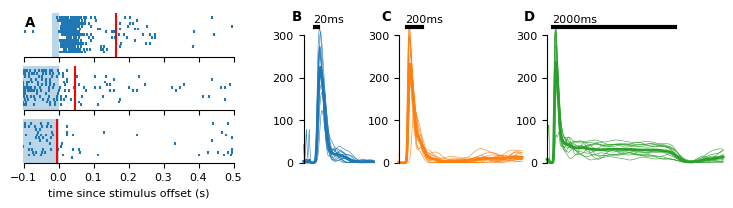

In [15]:
kde_xx = np.linspace(-1, 5, 1000)

fig = plt.figure(figsize=(7, 1.5))

gs_rasters = fig.add_gridspec(3,1, top=1, bottom=0., left=0, right=0.3)

axes = [fig.add_subplot(gs_rasters[i]) for i in range(3)]

for i, (ax, dur) in enumerate(zip(axes, [0.02, 0.2, 2])):
    _, spiketrains, ends = get_data(dur)
    ax.eventplot(spiketrains)
    ax.set_xlim(-0.1, 0.5)
    ax.axvspan(-dur, 0, alpha=0.3)
    ax.axvline(np.nanmedian(ends)-dur, color='red')
    despine_ax(ax, where='l')
    
    if i != 2:
        ax.set_xticklabels([])

ax.set_xlabel('time since stimulus offset (s)')
axes[0].set_title('A', fontweight='bold', x=0.03, y=0.5)

gs_kdes = fig.add_gridspec(1,3, top=0.85, bottom=0., left=0.4, right=1, width_ratios=[0.4, 0.7, 1])

axes = [fig.add_subplot(gs_kdes[i]) for i in range(3)]

for i, (ax, dur, xmax, l) in enumerate(zip(axes, [0.02, 0.2, 2], [0.5, 1.5, 2.8], ['B','C','D'])):
    _, spiketrains, __ = get_data(dur)
    kdes = []
    mask = (kde_xx > -0.1) & (kde_xx < xmax)
    for st in spiketrains:
        kde = get_kde(kde_xx, st+dur, bw_func)
        kdes.append(kde)
        ax.plot(kde_xx[mask], kde[mask], c=f'C{i}', lw=0.4, clip_on=False)
    
    ax.plot(kde_xx[mask], np.mean(kdes, axis=0)[mask], c=f'C{i}', lw=2, clip_on=False)
        
    ax.set_ylim(0, 300)
    ax.set_xlim(-0.1, xmax)
    
    ax.plot([0,0+dur],[320,320], lw=3, color='black', clip_on=False)
    ax.text(-0.02, 330, f'{dur*1000:.0f}ms', ha='left')
    
    despine_ax(ax, where='b')
    ax.set_title(l, fontweight='bold', x=-0.1, y=1.05)